In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

# For downloading stock data
import yfinance as yf


In [ ]:
# Downloading the historical stock data
data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')

# Displaying the first few rows of the dataset
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.461977  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.473149  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.370184  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.358408  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.400679  447610800


In [ ]:
# Selecting the 'Close' column for prediction
data = data[['Close']]

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Creating a dataset with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [ ]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, batch_size=1, epochs=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3212/3212 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - loss: 0.0030


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


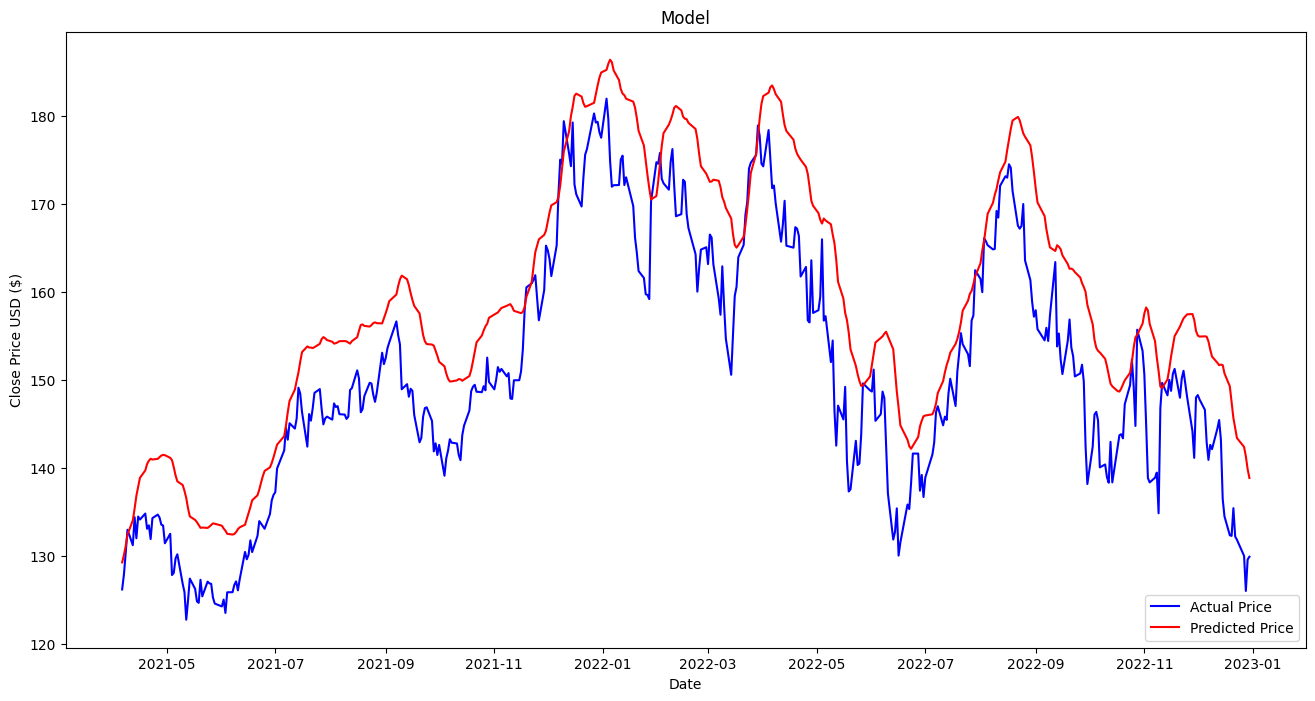

RMSE: 9.066845689953821


In [ ]:
# Creating the test dataset
test_data = scaled_data[-500:]
X_test = []
y_test = data[-500:].values

# The loop started at 60, leaving out the first 60 values of 'y_test' for comparison
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Getting the predicted stock price
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Adjusting 'y_test' to match the number of predictions
y_test = y_test[60:] # Now 'y_test' and 'predictions' have the same length

# Plotting the results
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(data.index[-len(y_test):], y_test, color='blue', label='Actual Price')
plt.plot(data.index[-len(predictions):], predictions, color='red', label='Predicted Price')
plt.legend(loc='lower right')
plt.show()

# Calculating the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test)**2)) # Squaring the difference before taking the mean
print(f'RMSE: {rmse}')